In [12]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
from IPython.display import display, HTML


%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import shapely as sp
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader

import os


## Contents

* [Approach](#section_approach)
* [Import Deprivation Index Data: LSOA Level](#section_depriv_lsoa)
* [Import Geo-Data: LSOA Level](## Import-Geo-Data:-LSOA-Level)

<a id="section_approach"></a>

---

## Approach


#### Geo-data

There are 3 levels of administrative geo-data in England

* Local Authority Districts (LAD)
    * [geodata source](http://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2011-gb-bgc) - 2011 boundaries (because this is what the deprivation data is officially matched with), resolution: generalised, not WGS84
* Wards
    * [geodata source](http://geoportal.statistics.gov.uk/datasets/wards-december-2017-generalised-clipped-boundaries-in-great-britain) - 2017 boundaries, resolution: generalised, not WGS84
* Lower Super Output Areas (LSOA) 
    * [geodata source](http://geoportal.statistics.gov.uk/datasets/da831f80764346889837c72508f046fa_2) - 2011 boundaries (this is the latest year for LSOAs), resolution: generalised, not WGS84
    
    
Note for some confusing terms in the geo-datasets' names:

* BFC Boundary - Full resolution, Clipped to the coastline
* BFE Boundary - Full resolution, Extent of the realm
* BGC Boundary - Generalised (20m), Clipped to the coastline
* BGE Boundary - Generalised (20m), Extent of the realm
* BSC Boundary - Super Generalised (200m), Clipped to the coastline
* BSE Boundary - Super Generalised (200m), Extent of the realm

#### Deprivation data

Deprivation index data is at the LSOA level, but is already officially aggregated at the LAD level. So we need to produce our own aggregation at the Ward level. This is made more complicated because wards and LSOAs don't usually map neatly into one another, as described in [this github issue](https://github.com/yanoak/360giving-deprivation/issues/8). A workaround is to have an [official lookup table](http://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-area-2011-to-ward-2017-lookup-in-england-and-wales) that matches LSOAs (2011) to Wards (2017) using a [best fitting method](http://geoportal.statistics.gov.uk/datasets?q=Building%202011%20Census%20estimates) that relies on population weighted centroids of Output Areas.

Datasets:

* [LSOAs 2011 to Wards 2017 lookup table](http://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-area-2011-to-ward-2017-lookup-in-england-and-wales)
* [English Indices of Deprivation 2015 - LSOA Level (csv)](http://opendatacommunities.org/data/societal-wellbeing/imd/indices)
* [English Indices of Deprivation 2015 - Summaries at Local Authority Level (csv)](http://opendatacommunities.org/data/societal-wellbeing/imd/indicesbyla)
* [Other associated info/files for English Indices of Deprivation with xlsx files of LAD and LSOA level deprivation](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2015)
* [Reseach report](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/464597/English_Indices_of_Deprivation_2015_-_Research_Report.pdf) Section 3.3 contains guidance on how to interpret higher level geography summaries

&nbsp;

<a id="section_depriv_lsoa"></a>

---


## Import Deprivation Index Data: LSOA Level

Source: [Homepage](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2015)

[File 2: Domains of Deprivation](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/467765/File_2_ID_2015_Domains_of_deprivation.xlsx)

In [13]:
dp_lsoa_df = pd.read_excel('../data/deprivation/File_2_ID_2015_Domains_of_deprivation.xlsx', sheet_name='ID2015 Domains', index_col=[0])


In [14]:
dp_lsoa_df.columns

Index(['LSOA name (2011)', 'Local Authority District code (2013)',
       'Local Authority District name (2013)',
       'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)',
       'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
       'Income Rank (where 1 is most deprived)',
       'Income Decile (where 1 is most deprived 10% of LSOAs)',
       'Employment Rank (where 1 is most deprived)',
       'Employment Decile (where 1 is most deprived 10% of LSOAs)',
       'Education, Skills and Training Rank (where 1 is most deprived)',
       'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)',
       'Health Deprivation and Disability Rank (where 1 is most deprived)',
       'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)',
       'Crime Rank (where 1 is most deprived)',
       'Crime Decile (where 1 is most deprived 10% of LSOAs)',
       'Barriers to Housing and Services R

In [15]:
dp_lsoa_df.rename(index=str, columns={'LSOA name (2011)' : 'LSOA2011_NM', \
        'Local Authority District code (2013)' : 'LAD2013_CD', \
        'Local Authority District name (2013)' : 'LAD2013_NM', \
        'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)' : 'imd_rank', \
        'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)' : 'imd_dec', \
        'Income Rank (where 1 is most deprived)' : 'income_rank', \
        'Income Decile (where 1 is most deprived 10% of LSOAs)' : 'incom_dec', \
        'Employment Rank (where 1 is most deprived)' : 'employment_rank', \
        'Employment Decile (where 1 is most deprived 10% of LSOAs)' : 'employment_dec', \
        'Education, Skills and Training Rank (where 1 is most deprived)' : 'education_rank', \
        'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)' : 'education_dec', \
        'Health Deprivation and Disability Rank (where 1 is most deprived)' : 'health_rank', \
        'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)' : 'health_dec', \
        'Crime Rank (where 1 is most deprived)' : 'crime_rank', \
        'Crime Decile (where 1 is most deprived 10% of LSOAs)' : 'crime_dec', \
        'Barriers to Housing and Services Rank (where 1 is most deprived)' : 'housing_rank', \
        'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)' : 'housing_dec', \
        'Living Environment Rank (where 1 is most deprived)' : 'environment_rank', \
        'Living Environment Decile (where 1 is most deprived 10% of LSOAs)' : 'environment_dec' \
        }, inplace=True)

In [16]:
dp_lsoa_df.index.names = ['LSOA2011_CD']

In [17]:
dp_lsoa_df.head()

,LSOA2011_NM,LAD2013_CD,LAD2013_NM,imd_rank,imd_dec,income_rank,incom_dec,employment_rank,employment_dec,education_rank,education_dec,health_rank,health_dec,crime_rank,crime_dec,housing_rank,housing_dec,environment_rank,environment_dec
LSOA2011_CD,,,,,,,,,,,,,,,,,,,
E01031349,Adur 001A,E07000223,Adur,21352,7,18992,6,19305,6,13727,5,25876,8,12817,4,28166,9,18367,6
E01031350,Adur 001B,E07000223,Adur,8864,3,9233,3,7879,3,6969,3,6883,3,12781,4,11399,4,16242,5
E01031351,Adur 001C,E07000223,Adur,22143,7,24539,8,23389,8,10213,4,24693,8,9112,3,24743,8,22299,7
E01031352,Adur 001D,E07000223,Adur,17252,6,16087,5,13699,5,10468,4,19627,6,16127,5,19559,6,22819,7
E01031370,Adur 001E,E07000223,Adur,15643,5,17918,6,13322,5,7819,3,14893,5,13723,5,22433,7,18191,6


<a id="section_depriv_lad"></a>

---

## Import Deprivation Index Data: LAD Level

Source: [Homepage](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2015)

[File 10: Local Authority District Summaries](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/464464/File_10_ID2015_Local_Authority_District_Summaries.xlsx)

The aggregation produces a lot of different measures such as ranks and ranks of ranks. We are only interested in the average score, which is weighted by the population of the LSOAs that make up the LAD

In [18]:
lad_vars = [
    {'sheet': 'IMD', 'col': 'IMD - Average score'},
    {'sheet': 'Income', 'col': 'Income - Average score'},
    {'sheet': 'Employment', 'col': 'Employment - Average score'},
    {'sheet': 'Education', 'col': 'Education, Skills and Training - Average score'},
    {'sheet': 'Health', 'col': 'Health Deprivation and Disability - Average score'},
    {'sheet': 'Crime', 'col': 'Crime - Average score'},
    {'sheet': 'Barriers', 'col': 'Barriers to Housing and Services - Average score'},
    {'sheet': 'Living', 'col': 'Living Environment - Average score'}
]

In [19]:
lad_df = pd.DataFrame()

In [20]:
for i, v in enumerate(lad_vars):
    #print(v['sheet'],i)
    df = pd.read_excel('../data/deprivation/File_10_ID2015_Local_Authority_District_Summaries.xlsx', sheet_name=v['sheet'])
    df.rename(index=str, columns={'Local Authority District code (2013)' : 'LAD2013_CD', \
        'Local Authority District name (2013)' : 'LAD2013_NM', \
        v['col'] : v['sheet']+'_avg_score', \
        }, inplace=True)
    if i == 0:
        lad_df = lad_df.append(df[['LAD2013_CD','LAD2013_NM',v['sheet']+'_avg_score']])
    else:
        lad_df = pd.merge(lad_df, df[['LAD2013_CD',v['sheet']+'_avg_score']], on='LAD2013_CD',sort=True)
    
#dp_lad_df = pd.read_excel('../data/deprivation/File_10_ID2015_Local_Authority_District_Summaries.xlsx', sheet_name='ID2015 Domains', index_col=[0])

display(lad_df.head())

,LAD2013_CD,LAD2013_NM,IMD_avg_score,Income_avg_score,Employment_avg_score,Education_avg_score,Health_avg_score,Crime_avg_score,Barriers_avg_score,Living_avg_score
0,E06000001,Hartlepool,33.178,0.239,0.211,30.510,0.929,0.078,13.128,8.260
1,E06000002,Middlesbrough,40.216,0.268,0.216,40.640,1.195,0.633,18.316,12.907
2,E06000003,Redcar and Cleveland,28.567,0.204,0.186,27.875,0.752,-0.013,12.863,7.923
3,E06000004,Stockton-on-Tees,24.625,0.177,0.156,24.637,0.548,-0.263,17.844,7.068
4,E06000005,Darlington,23.639,0.168,0.150,22.569,0.502,0.224,12.346,10.710


In [21]:
deprivation_colums = {'IMD_avg_score':'comparison_IMD_avg_score', \
                        'Income_avg_score':'comparison_Income_avg_score', \
                        'Employment_avg_score':'comparison_Employment_avg_score', \
                        'Education_avg_score':'comparison_Education_avg_score', \
                        'Health_avg_score':'comparison_Health_avg_score', \
                        'Crime_avg_score':'comparison_Crime_avg_score', \
                        'Barriers_avg_score':'comparison_Barriers_avg_score', \
                        'Living_avg_score':'comparison_Living_avg_score' }

lad_df.rename(index=str, columns=deprivation_colums, inplace=True)

display(lad_df.head())

,LAD2013_CD,LAD2013_NM,comparison_IMD_avg_score,comparison_Income_avg_score,comparison_Employment_avg_score,comparison_Education_avg_score,comparison_Health_avg_score,comparison_Crime_avg_score,comparison_Barriers_avg_score,comparison_Living_avg_score
0,E06000001,Hartlepool,33.178,0.239,0.211,30.510,0.929,0.078,13.128,8.260
1,E06000002,Middlesbrough,40.216,0.268,0.216,40.640,1.195,0.633,18.316,12.907
2,E06000003,Redcar and Cleveland,28.567,0.204,0.186,27.875,0.752,-0.013,12.863,7.923
3,E06000004,Stockton-on-Tees,24.625,0.177,0.156,24.637,0.548,-0.263,17.844,7.068
4,E06000005,Darlington,23.639,0.168,0.150,22.569,0.502,0.224,12.346,10.710


---

## Import Charities Data: Postcode Level

* Source - [CharityBase](https://charitybase.uk/)
* Source - [PostCode to ward and LAD lookup](https://ons.maps.arcgis.com/home/item.html?id=c4aeb11ff5b045018b7340e807d645cb)
* Source - [PostCode to Output Areas lookup](http://geoportal1-ons.opendata.arcgis.com/datasets/80628f9289574ba4b39a76ca7830b7e9_0)
* Source - [Output Area to Ward to Local Authority District (December 2017) Lookup in England and Wales](https://geoportal.statistics.gov.uk/datasets/988e581ac9d942dfa6d642c4e98b048c_0)

In [22]:
postcode_df = pd.read_csv('../data/geo/pcd11_par11_wd11_lad11_ew_lu.csv',encoding='iso-8859-1')

postcode_to_oa_df = pd.read_csv('../data/geo/Postcode_to_Output_Area_to_Lower_Layer_Super_Output_Area_to_Middle_Layer_Super_Output_Area_to_Local_Authority_District_February_2018_Lookup_in_the_UK.csv',encoding='iso-8859-1')

oa_to_ward_2017 = pd.read_csv('../data/geo/Output_Area_to_Ward_to_Local_Authority_District_December_2017_Lookup_in_England_and_Wales.csv',encoding='iso-8859-1')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
oa_to_ward_2017.head()

,OA11CD,WD17CD,WD17NM,WD17NMW,LAD17CD,LAD17NM,FID
0,E00069981,E05001828,Bridge,NaN,E06000018,Nottingham,10001
1,E00069980,E05001828,Bridge,NaN,E06000018,Nottingham,10002
2,E00069988,E05001828,Bridge,NaN,E06000018,Nottingham,10003
3,E00173541,E05001828,Bridge,NaN,E06000018,Nottingham,10004
4,E00173506,E05001828,Bridge,NaN,E06000018,Nottingham,10005


In [24]:
postcode_to_oa_df.head()

,pcd7,pcd8,pcds,dointr,doterm,usertype,oa11,lsoa11cd,msoa11cd,ladcd,lsoa11nm,msoa11nm,ladnm,ladnmw,FID
0,AB1 1EZ,AB1 1EZ,AB1 1EZ,198001,199606,0,S00090528,S01006645,S02001261,S12000033,George Street - 01,George Street,Aberdeen City,NaN,1
1,AB1 0AA,AB1 0AA,AB1 0AA,198001,199606,0,S00090303,S01006514,S02001237,S12000033,"Cults, Bieldside and Milltimber West - 02","Cults, Bieldside and Milltimber West",Aberdeen City,NaN,2
2,AB1 0RE,AB1 0RE,AB1 0RE,198001,199606,0,S00090294,S01006507,S02001236,S12000033,Culter - 02,Culter,Aberdeen City,NaN,3
3,AB1 1FA,AB1 1FA,AB1 1FA,198001,199606,0,S00090532,S01006645,S02001261,S12000033,George Street - 01,George Street,Aberdeen City,NaN,4
4,AB1 0RF,AB1 0RF,AB1 0RF,199210,199606,0,S00090296,S01006507,S02001236,S12000033,Culter - 02,Culter,Aberdeen City,NaN,5


In [25]:
postcode_to_ward2017_df_merged = pd.merge(postcode_to_oa_df, oa_to_ward_2017, left_on='oa11', right_on='OA11CD',sort=True)


In [26]:
postcode_to_ward2017_df_merged = postcode_to_ward2017_df_merged[['pcd8','WD17CD','WD17NM','ladcd','ladnm']]
postcode_to_ward2017_df_merged.head()

,pcd8,WD17CD,WD17NM,ladcd,ladnm
0,EC2Y 8NJ,E05009288,Aldersgate,E09000001,City of London
1,EC2Y 8DR,E05009288,Aldersgate,E09000001,City of London
2,EC2Y 8PE,E05009288,Aldersgate,E09000001,City of London
3,EC2Y 8BY,E05009288,Aldersgate,E09000001,City of London
4,EC2Y 8DP,E05009288,Aldersgate,E09000001,City of London


In [27]:
postcode_df = postcode_df[['pcd8','wd11cd','wd11nm','lad11cd','lad11nm']]
postcode_df.head()

,pcd8,wd11cd,wd11nm,lad11cd,lad11nm
0,AL1 1AG,E05004802,Sopwell,E07000100,St Albans
1,AL1 1AJ,E05004802,Sopwell,E07000100,St Albans
2,AL1 1AR,E05004789,Cunningham,E07000100,St Albans
3,AL1 1AS,E05004799,St Peters,E07000100,St Albans
4,AL1 1BH,E05004802,Sopwell,E07000100,St Albans


In [28]:
postcode_df.describe()

,pcd8,wd11cd,wd11nm,lad11cd,lad11nm
count,1308780,1308780,1308780,1308780,1308780
unique,1308780,8573,7815,348,348
top,NE15 9PQ,E05000649,Castle,E06000052,Cornwall
freq,1,1405,4436,18543,18543


In [29]:
postcode_to_ward17_to_lad11_lookup = pd.merge(postcode_to_ward2017_df_merged, postcode_df, \
                                              left_on='pcd8', right_on='pcd8',sort=True)



In [30]:
aggregagations = {'pcd8': 'count'}

ward17_to_lad11_lookup =  pd.pivot_table(postcode_to_ward17_to_lad11_lookup, index=['WD17CD','lad11cd'],\
                                         aggfunc = aggregagations)
ward17_to_lad11_lookup.reset_index(inplace=True)


In [31]:
ward17_to_lad11_lookup.head()

,WD17CD,lad11cd,pcd8
0,E05000026,E09000002,158
1,E05000027,E09000002,136
2,E05000028,E09000002,157
3,E05000029,E09000002,170
4,E05000030,E09000002,145


In [32]:
cb_df = pd.read_csv('../data/comparison/charity-base-1548222944.csv',encoding='iso-8859-1')


In [33]:
cb_df.head(3)

,name,ids.GB-CHC,contact.address,contact.email,contact.geo.latitude,contact.geo.longitude,contact.person,contact.phone,contact.postcode
0,The British Council,209131,"[""The British Council"",""10 Spring Gardens"",""Lo...",trustees@britishcouncil.org,51.506999,-0.129744,Ms Alison Coutts,NaN,SW1A 2BN
1,Nuffield Health,205533,"[""Nuffield Health"",""Epsom Gateway"",""2 Ashley A...",toby.newman@nuffieldhealth.com,51.331616,-0.270322,Mr Toby Newman,01372426885,KT18 5AL
2,Lloyd'S Register Foundation,1145988,"[""71 Fenchurch Street"",""London""]",michelle.davies@lr.org,51.512507,-0.078733,Michelle Davies,0207 423 2783,EC3M 4BS


In [34]:
cb_df_merged = pd.merge(cb_df, postcode_to_ward2017_df_merged, left_on='contact.postcode', right_on='pcd8',sort=True)


In [35]:
cb_df_merged = pd.merge(cb_df_merged, postcode_df, left_on='contact.postcode', right_on='pcd8',sort=True)


In [36]:
cb_df_merged.head()

,name,ids.GB-CHC,contact.address,contact.email,contact.geo.latitude,contact.geo.longitude,contact.person,contact.phone,contact.postcode,pcd8_x,WD17CD,WD17NM,ladcd,ladnm,pcd8_y,wd11cd,wd11nm,lad11cd,lad11nm
0,Wellfield Trust,296205,"[""Birchwood Leisure Centre"",""Longmead"",""Hatfie...",wellfieldtrust@aol.com,51.773918,-0.220092,Mrs Jeanette Bayford,01707 251018,AL10 0AN,AL10 0AN,E05011061,Hatfield Central,E07000241,Welwyn Hatfield,AL10 0AN,E05004853,Hatfield Central,E07000104,Welwyn Hatfield
1,Birchwood And De Havilland Grange Playing Fields,1142401,"[""Birchwood Leisure Centre"",""Longmead"",""Hatfie...",carrie.lloyd@hatfield-herts.gov.uk,51.773918,-0.220092,Hatfield Town Council,01707262023,AL10 0AN,AL10 0AN,E05011061,Hatfield Central,E07000241,Welwyn Hatfield,AL10 0AN,E05004853,Hatfield Central,E07000104,Welwyn Hatfield
2,Hatfield And District Age Concern,246689,"[""Hatfield & District Age Concern"",""Friendship...",friendship.house@btconnect.com,51.765924,-0.228392,Mr Steve Russell,NaN,AL10 0BU,AL10 0BU,E05011061,Hatfield Central,E07000241,Welwyn Hatfield,AL10 0BU,E05004853,Hatfield Central,E07000104,Welwyn Hatfield
3,Redeemed Christian Church Of God Open Heavens ...,1149053,"[""62A Town Centre"",""Hatfield""]",openheavenschristiancentre@yahoo.co.uk,51.763786,-0.226751,Mrs Odunayo Fabiyi,01707268022,AL10 0JJ,AL10 0JJ,E05011061,Hatfield Central,E07000241,Welwyn Hatfield,AL10 0JJ,E05004853,Hatfield Central,E07000104,Welwyn Hatfield
4,The King'S Community Church Hatfield Trust,1144204,"[""Kennelwood House"",""Kennelwood Lane"",""Hatfield""]",kcchatfield@hotmail.co.uk,51.762979,-0.225295,Lizzie Stacey,01707256100,AL10 0LG,AL10 0LG,E05011061,Hatfield Central,E07000241,Welwyn Hatfield,AL10 0LG,E05004853,Hatfield Central,E07000104,Welwyn Hatfield


In [37]:
cb_df_merged.to_csv('../data/comparison/cb_df_merged.csv')

In [38]:
aggregagations = {'ids.GB-CHC': 'count'}

cb_lad_pivot_df = pd.pivot_table(cb_df_merged, index=['lad11cd'], aggfunc = aggregagations)
cb_lad_pivot_df.reset_index(inplace=True)

cb_lad_pivot_df = cb_lad_pivot_df[cb_lad_pivot_df.lad11cd.astype(str).str[0] == 'E']

cb_lad_pivot_df.rename(index=str, columns={'ids.GB-CHC' : 'comparison_Number_of_charities'}, inplace=True)

In [39]:
cb_lad_pivot_df.head()

,lad11cd,comparison_Number_of_charities
0,E06000001,105
1,E06000003,145
2,E06000004,214
3,E06000005,2
4,E06000006,1


In [40]:
aggregagations = {'ids.GB-CHC': 'count'}

cb_ward_pivot_df = pd.pivot_table(cb_df_merged, index=['WD17CD'], aggfunc = aggregagations)
cb_ward_pivot_df.reset_index(inplace=True)

cb_ward_pivot_df = cb_ward_pivot_df[cb_ward_pivot_df.WD17CD.astype(str).str[0] == 'E']

cb_ward_pivot_df.rename(index=str, columns={'ids.GB-CHC' : 'comparison_Number_of_charities'}, inplace=True)

In [41]:
cb_ward_pivot_df.head()

,WD17CD,comparison_Number_of_charities
0,E05000026,28
1,E05000027,14
2,E05000028,1
3,E05000030,14
4,E05000031,6


In [42]:
cb_ward_pivot_df.describe()

,comparison_Number_of_charities
count,4083.000000
mean,14.632133
std,12.749936
min,1.000000
25%,7.000000
50%,12.000000
75%,19.000000
max,329.000000


---

## Import Population Data

Source - [ONS Open Geography Portal](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental)

In [43]:
pop_ward_df = pd.read_excel('../data/comparison/SAPE20DT8-mid-2017-ward-2017-syoa-estimates-unformatted.xls', sheet_name='Mid-2017 Persons', index_col=[0],skiprows=4)


In [44]:
pop_ward_df.reset_index(inplace=True)
pop_ward_df = pop_ward_df[['Ward Code 1','Ward Name 1','All Ages']]
pop_ward_df.rename(index=str, columns={'All Ages' : 'comparison_Population_Estimate'}, inplace=True)

In [45]:
pop_ward_df.head()

,Ward Code 1,Ward Name 1,comparison_Population_Estimate
0,E05000026,Abbey,15460.0
1,E05000027,Alibon,10995.0
2,E05000028,Becontree,14862.0
3,E05000029,Chadwell Heath,11265.0
4,E05000030,Eastbrook,11473.0


In [46]:
aggregagations = {'pcd8': 'count'}

postcode_df_ward_lad = pd.pivot_table(postcode_df, index=['wd11cd','lad11cd'], aggfunc = aggregagations)
postcode_df_ward_lad.reset_index(inplace=True)


In [47]:
pop_ward_lad_df = pd.merge(pop_ward_df, ward17_to_lad11_lookup, left_on='Ward Code 1', \
                           right_on='WD17CD',sort=True, how='left')
pop_ward_lad_df = pop_ward_lad_df[pop_ward_lad_df['Ward Code 1'].astype(str).str[0] == 'E']
pop_ward_lad_df = pop_ward_lad_df[pop_ward_lad_df['comparison_Population_Estimate'].notnull()]

In [48]:
aggregagations = {'comparison_Population_Estimate': 'sum'}

pop_lad_df = pd.pivot_table(pop_ward_lad_df, index=['lad11cd'], aggfunc = aggregagations)
pop_lad_df.reset_index(inplace=True)


In [49]:
pop_lad_df.head()

,lad11cd,comparison_Population_Estimate
0,E06000001,93019.0
1,E06000002,140639.0
2,E06000003,136005.0
3,E06000004,196487.0
4,E06000005,106347.0


---

## Import Geo-Data: LSOA Level

Source - [ONS Open Geography Portal](http://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-areas-december-2011-super-generalised-clipped-boundaries-in-england-and-wales/data)

In [50]:
gdf = gpd.read_file('../data/geo/Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales/Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp')
gdf.set_index('lsoa11cd',inplace=True)
gdf.index.names = ['LSOA2011_CD']
gdf = gdf[gdf.index.astype(str).str[0] == 'E']
gdf.reset_index(inplace=True)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=4326)

In [51]:
gdf.head()

,LSOA2011_CD,objectid,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry
0,E01000001,1,City of London 001A,City of London 001A,133320.768872,2291.846072,POLYGON ((-0.09728867323202922 51.521577042020...
1,E01000002,2,City of London 001B,City of London 001B,226191.272990,2433.960112,POLYGON ((-0.08812915078150368 51.519410719510...
2,E01000003,3,City of London 001C,City of London 001C,57302.966538,1142.359799,POLYGON ((-0.0967857370545377 51.5232494901361...
3,E01000005,4,City of London 001E,City of London 001E,190738.760504,2167.868343,POLYGON ((-0.07323093900475477 51.510002398683...
4,E01000006,5,Barking and Dagenham 016A,Barking and Dagenham 016A,144195.846857,1935.510354,POLYGON ((0.09115207554164177 51.5390853019798...


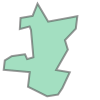

In [52]:
display(gdf.loc[0,'geometry'])

In [53]:
gdf_lsoa = gdf

---

## Import Geo-Data: LAD Level

Source - [ONS Open Geography Portal](http://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2011-gb-bgc)


In [54]:
gdf = gpd.read_file('../data/geo/Local_Authority_Districts_December_2011_GB_BGC/Local_Authority_Districts_December_2011_GB_BGC.shp')

gdf.set_index('lad11cd',inplace=True)
gdf.index.names = ['LAD2011_CD']
gdf = gdf[gdf.index.astype(str).str[0] == 'E']
gdf.reset_index(inplace=True)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=4326)

gdf.head()

,LAD2011_CD,objectid,lad11cdo,lad11nm,lad11nmw,st_areasha,st_lengths,geometry
0,E06000001,1,00EB,Hartlepool,None,9.389290e+07,68996.677754,(POLYGON ((-1.270237406245723 54.7271584031430...
1,E06000002,2,00EC,Middlesbrough,None,5.386184e+07,44917.925537,(POLYGON ((-1.230015802826847 54.5840956722952...
2,E06000003,3,00EE,Redcar and Cleveland,None,2.449159e+08,93270.866874,(POLYGON ((-1.137165952757933 54.6469344081215...
3,E06000004,4,00EF,Stockton-on-Tees,None,2.039201e+08,155579.742599,(POLYGON ((-1.317985542636292 54.6452624807959...
4,E06000039,39,00MD,Slough,None,3.253413e+07,43424.361153,POLYGON ((-0.6247880291356083 51.5380032936336...


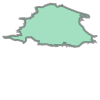

In [55]:
display(gdf.loc[0,'geometry'])

In [56]:
gdf_lad = gdf

---

## Import Geo-Data: Ward Level

Source - [LSOAs 2011 to Wards 2017 lookup table](http://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-area-2011-to-ward-2017-lookup-in-england-and-wales)

In [57]:
gdf = gpd.read_file('../data/geo/Wards_December_2017_Generalised_Clipped_Boundaries_in_Great_Britain/Wards_December_2017_Generalised_Clipped_Boundaries_in_Great_Britain.shp')

gdf.set_index('wd17cd',inplace=True)
#gdf.index.names = ['LAD2011_CD']
gdf = gdf[gdf.index.astype(str).str[0] == 'E']
gdf.reset_index(inplace=True)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=4326)

gdf.head()

,wd17cd,objectid,wd17nm,wd17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,E05000026,1,Abbey,None,544434,184378,0.081291,51.539799,1.247620e+06,7858.341538,(POLYGON ((0.07134621115186986 51.537247597410...
1,E05000027,2,Alibon,None,549247,185196,0.150987,51.545898,1.355411e+06,6246.797017,POLYGON ((0.1563507181798993 51.55101883054941...
2,E05000028,3,Becontree,None,546863,185869,0.116912,51.552601,1.289741e+06,6280.315821,POLYGON ((0.1249895183523908 51.56434101285452...
3,E05000029,4,Chadwell Heath,None,548266,189340,0.138596,51.583401,3.382318e+06,9496.494913,"POLYGON ((0.1300262084289008 51.5707532745533,..."
4,E05000030,5,Eastbrook,None,550774,186272,0.173453,51.555199,3.449511e+06,8857.773001,POLYGON ((0.1563507181798993 51.55101883054941...


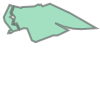

In [58]:
display(gdf.loc[0,'geometry'])

In [59]:
gdf_ward = gdf

---

## Map LSOA Deprivation data to Ward Level

Sources: 
* [LSOAs 2011 to Wards 2017 lookup table](http://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-area-2011-to-ward-2017-lookup-in-england-and-wales)
* [Indices of Deprivation Homepage](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2015) - [File 7: all ranks, deciles and scores for the indices of deprivation, and population denominators](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/467774/File_7_ID_2015_All_ranks__deciles_and_scores_for_the_Indices_of_Deprivation__and_population_denominators.csv/preview)


In [60]:
lookup_df = pd.read_csv('../data/geo/Lower_Layer_Super_Output_Area_2011_to_Ward_2017_Lookup_in_England_and_Wales.csv')

#lookup_df.head()

In [61]:
deprivation_all_df =  pd.read_csv('../data/deprivation/File_7_ID_2015_All_ranks__deciles_and_scores_for_the_Indices_of_Deprivation__and_population_denominators.csv')

#deprivation_all_df.head()

In [62]:
ward_lsoa_merged = pd.merge(lookup_df, deprivation_all_df, left_on='LSOA11CD', right_on='LSOA code (2011)',sort=True)

deprivation_colums = [{'oldvar': 'Index of Multiple Deprivation (IMD) Score', 'newvar':'comparison_IMD_avg_score'}, \
                        {'oldvar': 'Income Score (rate)', 'newvar':'comparison_Income_avg_score'}, \
                        {'oldvar': 'Employment Score (rate)', 'newvar':'comparison_Employment_avg_score'}, \
                        {'oldvar': 'Education, Skills and Training Score', 'newvar':'comparison_Education_avg_score'}, \
                        {'oldvar': 'Health Deprivation and Disability Score', 'newvar':'comparison_Health_avg_score'}, \
                        {'oldvar': 'Crime Score', 'newvar':'comparison_Crime_avg_score'}, \
                        {'oldvar': 'Barriers to Housing and Services Score', 'newvar':'comparison_Barriers_avg_score'}, \
                        {'oldvar': 'Living Environment Score', 'newvar':'comparison_Living_avg_score'}]


ward_lsoa_merged = ward_lsoa_merged[['LSOA11CD','LSOA11NM','WD17CD','WD17NM','WD17NMW','LAD17CD','LAD17NM']
                                    + [c['oldvar'] for c in deprivation_colums]
                                    + ['Total population: mid 2012 (excluding prisoners)']]
ward_lsoa_merged.head()

,LSOA11CD,LSOA11NM,WD17CD,WD17NM,WD17NMW,LAD17CD,LAD17NM,Index of Multiple Deprivation (IMD) Score,Income Score (rate),Employment Score (rate),"Education, Skills and Training Score",Health Deprivation and Disability Score,Crime Score,Barriers to Housing and Services Score,Living Environment Score,Total population: mid 2012 (excluding prisoners)
0,E01000001,City of London 001A,E05009288,Aldersgate,NaN,E09000001,City of London,6.063,0.011,0.015,0.021,-1.918,-1.649,27.134,34.502,1469
1,E01000002,City of London 001B,E05009302,Cripplegate,NaN,E09000001,City of London,6.255,0.012,0.017,0.040,-1.931,-1.692,26.358,37.106,1469
2,E01000003,City of London 001C,E05009302,Cripplegate,NaN,E09000001,City of London,19.548,0.105,0.088,9.612,0.321,-0.987,31.861,48.337,1421
3,E01000005,City of London 001E,E05009308,Portsoken,NaN,E09000001,City of London,26.005,0.217,0.144,15.045,0.050,-0.831,35.104,34.811,1014
4,E01000006,Barking and Dagenham 016A,E05000026,Abbey,NaN,E09000002,Barking and Dagenham,22.568,0.133,0.094,14.525,-0.390,0.746,39.737,30.477,1794


#### Calculate population weighted averages of LSOA deprivations for each ward

In [63]:
wtavg = lambda x, c: np.average(x[c], weights = x['Total population: mid 2012 (excluding prisoners)'], axis = 0)

ward_deprivation = ward_lsoa_merged.groupby(['WD17CD','WD17NM']).size().reset_index(name='LSOA_counts').set_index('WD17CD')

for c in deprivation_colums:
    dfwavg = ward_lsoa_merged.groupby('WD17CD').apply(wtavg, c['oldvar'])
    ward_deprivation = pd.merge(ward_deprivation,pd.DataFrame(dfwavg,columns=[c['newvar']]), on='WD17CD',sort=True)

ward_deprivation = ward_deprivation.reset_index()
ward_deprivation.head()

,WD17CD,WD17NM,LSOA_counts,comparison_IMD_avg_score,comparison_Income_avg_score,comparison_Employment_avg_score,comparison_Education_avg_score,comparison_Health_avg_score,comparison_Crime_avg_score,comparison_Barriers_avg_score,comparison_Living_avg_score
0,E05000026,Abbey,7,33.084734,0.224387,0.122055,16.604366,0.091863,0.938570,48.529075,35.081641
1,E05000027,Alibon,6,38.235551,0.270853,0.180044,31.023750,0.588629,1.011638,36.485621,25.308429
2,E05000028,Becontree,8,35.369455,0.260072,0.168042,28.687858,0.489389,0.871280,33.679650,27.403831
3,E05000029,Chadwell Heath,6,35.026214,0.234857,0.157682,28.728325,0.497478,1.040609,36.237735,21.941597
4,E05000030,Eastbrook,7,26.797683,0.191430,0.141619,24.290097,0.178134,0.341267,32.634020,20.188132


In [64]:
ward_deprivation[['comparison_IMD_avg_score']].describe()

,comparison_IMD_avg_score
count,7427.000000
mean,18.912465
std,11.613879
min,1.269000
25%,10.394736
50%,15.743408
75%,24.834664
max,83.416700


---
## Merge Geo-data and Deprivation data at LAD level

In [65]:
#combined_gpd = gdf[['st_areasha','st_lengths','geometry']].join(lad_df)
combined_gpd = pd.DataFrame()
combined_gpd = pd.merge(gdf_lad[['LAD2011_CD','st_areasha','st_lengths','geometry']], lad_df, \
                  left_on='LAD2011_CD', right_on='LAD2013_CD',sort=True)

In [66]:
combined_gpd.head()

,LAD2011_CD,st_areasha,st_lengths,geometry,LAD2013_CD,LAD2013_NM,comparison_IMD_avg_score,comparison_Income_avg_score,comparison_Employment_avg_score,comparison_Education_avg_score,comparison_Health_avg_score,comparison_Crime_avg_score,comparison_Barriers_avg_score,comparison_Living_avg_score
0,E06000001,9.389290e+07,68996.677754,(POLYGON ((-1.270237406245723 54.7271584031430...,E06000001,Hartlepool,33.178,0.239,0.211,30.510,0.929,0.078,13.128,8.260
1,E06000002,5.386184e+07,44917.925537,(POLYGON ((-1.230015802826847 54.5840956722952...,E06000002,Middlesbrough,40.216,0.268,0.216,40.640,1.195,0.633,18.316,12.907
2,E06000003,2.449159e+08,93270.866874,(POLYGON ((-1.137165952757933 54.6469344081215...,E06000003,Redcar and Cleveland,28.567,0.204,0.186,27.875,0.752,-0.013,12.863,7.923
3,E06000004,2.039201e+08,155579.742599,(POLYGON ((-1.317985542636292 54.6452624807959...,E06000004,Stockton-on-Tees,24.625,0.177,0.156,24.637,0.548,-0.263,17.844,7.068
4,E06000005,1.974733e+08,105743.464662,POLYGON ((-1.637667569473506 54.61712823531258...,E06000005,Darlington,23.639,0.168,0.150,22.569,0.502,0.224,12.346,10.710


In [67]:
filename = '../data/geo/combined_deprivation_lad.json'

try: 
    os.remove(filename)
except OSError:
    pass
combined_gpd.to_file(filename, driver="GeoJSON")

In [68]:
combined_gpd[['comparison_IMD_avg_score']].describe()

,comparison_IMD_avg_score
count,320.00000
mean,19.53630
std,8.00989
min,5.00900
25%,12.89975
50%,18.05750
75%,25.25625
max,41.99700


In [69]:
combined_gpd[['comparison_Health_avg_score']].describe()

,comparison_Health_avg_score
count,320.000000
mean,-0.149766
std,0.653479
min,-2.191000
25%,-0.638250
50%,-0.191000
75%,0.352250
max,1.489000


---
## Merge Geo-data and Deprivation data at Ward level

In [70]:
combined_gpd = pd.DataFrame()
combined_gpd = pd.merge(gdf_ward[['wd17cd','geometry']], ward_deprivation, \
                  left_on='wd17cd', right_on='WD17CD',sort=True)
combined_gpd.drop(columns=['WD17CD'],inplace=True)

In [71]:
combined_gpd.head()

,wd17cd,geometry,WD17NM,LSOA_counts,comparison_IMD_avg_score,comparison_Income_avg_score,comparison_Employment_avg_score,comparison_Education_avg_score,comparison_Health_avg_score,comparison_Crime_avg_score,comparison_Barriers_avg_score,comparison_Living_avg_score
0,E05000026,(POLYGON ((0.07134621115186986 51.537247597410...,Abbey,7,33.084734,0.224387,0.122055,16.604366,0.091863,0.938570,48.529075,35.081641
1,E05000027,POLYGON ((0.1563507181798993 51.55101883054941...,Alibon,6,38.235551,0.270853,0.180044,31.023750,0.588629,1.011638,36.485621,25.308429
2,E05000028,POLYGON ((0.1249895183523908 51.56434101285452...,Becontree,8,35.369455,0.260072,0.168042,28.687858,0.489389,0.871280,33.679650,27.403831
3,E05000029,"POLYGON ((0.1300262084289008 51.5707532745533,...",Chadwell Heath,6,35.026214,0.234857,0.157682,28.728325,0.497478,1.040609,36.237735,21.941597
4,E05000030,POLYGON ((0.1563507181798993 51.55101883054941...,Eastbrook,7,26.797683,0.191430,0.141619,24.290097,0.178134,0.341267,32.634020,20.188132


In [72]:
filename = '../data/geo/combined_deprivation_ward.json'

try: 
    os.remove(filename)
except OSError:
    pass
combined_gpd.to_file(filename, driver="GeoJSON")

## Export just the Geo-data and Geo-code to place names lookup

### Ward level

In [89]:
gdf = gpd.read_file('../data/geo/Wards_December_2017_Generalised_Clipped_Boundaries_in_Great_Britain/Wards_December_2017_Generalised_Clipped_Boundaries_in_Great_Britain.shp')

gdf.set_index('wd17cd',inplace=True)
#gdf.index.names = ['LAD2011_CD']
gdf = gdf[gdf.index.astype(str).str[0] == 'E']
gdf.reset_index(inplace=True)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=4326)

filename = '../data/geo/geo_eng_ward.json'

try: 
    os.remove(filename)
except OSError:
    pass
gdf.to_file(filename, driver="GeoJSON")


### Ward level Lookup

In [102]:

filename_for_lookup = '../data/geo/geo_eng_ward_lookup.json'

df_for_lookup = pd.DataFrame(gdf)
df_for_lookup = df_for_lookup[['wd17cd','wd17nm']]
df_for_lookup.rename(columns={'wd17cd':'index','wd17nm':'value'},inplace=True)
df_for_lookup['key']=df_for_lookup['index']
df_for_lookup.set_index('index',inplace=True)

try: 
    os.remove(filename_for_lookup)
except OSError:
    pass
df_for_lookup.to_json(filename_for_lookup,orient='index')

### LAD level

In [109]:
gdf = gpd.read_file('../data/geo/Local_Authority_Districts_December_2011_GB_BGC/Local_Authority_Districts_December_2011_GB_BGC.shp')
gdf.set_index('lad11cd',inplace=True)
gdf.index.names = ['LAD2011_CD']
gdf = gdf[gdf.index.astype(str).str[0] == 'E']
gdf.reset_index(inplace=True)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=4326)

filename = '../data/geo/geo_eng_LAD.json'

try: 
    os.remove(filename)
except OSError:
    pass
gdf.to_file(filename, driver="GeoJSON")



### LAD level lookup

In [107]:

filename_for_lookup = '../data/geo/geo_eng_LAD_lookup.json'

df_for_lookup = pd.DataFrame(gdf)
display(df_for_lookup.head())
df_for_lookup = df_for_lookup[['LAD2011_CD','lad11nm']]
df_for_lookup.rename(columns={'LAD2011_CD':'index','lad11nm':'value'},inplace=True)
df_for_lookup['key']=df_for_lookup['index']
df_for_lookup.set_index('index',inplace=True)

try: 
    os.remove(filename_for_lookup)
except OSError:
    pass
df_for_lookup.to_json(filename_for_lookup,orient='index')

,LAD2011_CD,objectid,lad11cdo,lad11nm,lad11nmw,st_areasha,st_lengths,geometry
0,E06000001,1,00EB,Hartlepool,None,9.389290e+07,68996.677754,(POLYGON ((-1.270237406245723 54.7271584031430...
1,E06000002,2,00EC,Middlesbrough,None,5.386184e+07,44917.925537,(POLYGON ((-1.230015802826847 54.5840956722952...
2,E06000003,3,00EE,Redcar and Cleveland,None,2.449159e+08,93270.866874,(POLYGON ((-1.137165952757933 54.6469344081215...
3,E06000004,4,00EF,Stockton-on-Tees,None,2.039201e+08,155579.742599,(POLYGON ((-1.317985542636292 54.6452624807959...
4,E06000039,39,00MD,Slough,None,3.253413e+07,43424.361153,POLYGON ((-0.6247880291356083 51.5380032936336...


## Export just the Deprivation data

### Ward level

In [171]:
ward_deprivation.head()

,WD17CD,WD17NM,LSOA_counts,comparison_IMD_avg_score,comparison_Income_avg_score,comparison_Employment_avg_score,comparison_Education_avg_score,comparison_Health_avg_score,comparison_Crime_avg_score,comparison_Barriers_avg_score,comparison_Living_avg_score
0,E05000026,Abbey,7,33.084734,0.224387,0.122055,16.604366,0.091863,0.938570,48.529075,35.081641
1,E05000027,Alibon,6,38.235551,0.270853,0.180044,31.023750,0.588629,1.011638,36.485621,25.308429
2,E05000028,Becontree,8,35.369455,0.260072,0.168042,28.687858,0.489389,0.871280,33.679650,27.403831
3,E05000029,Chadwell Heath,6,35.026214,0.234857,0.157682,28.728325,0.497478,1.040609,36.237735,21.941597
4,E05000030,Eastbrook,7,26.797683,0.191430,0.141619,24.290097,0.178134,0.341267,32.634020,20.188132


In [172]:
out = '[' + ward_deprivation.to_json(orient='records')[1:-1] + ']'
with open('../data/comparison/comparison_eng_ward_deprivation.json', 'w') as f:
    f.write(out)

In [173]:
ward_deprivation.to_csv('../data/comparison/comparison_eng_ward_deprivation.csv.gz', compression='gzip')
ward_deprivation.to_csv('../data/comparison/comparison_eng_ward_deprivation.csv')


### LAD level

In [174]:
lad_df.head()

,LAD2013_CD,LAD2013_NM,comparison_IMD_avg_score,comparison_Income_avg_score,comparison_Employment_avg_score,comparison_Education_avg_score,comparison_Health_avg_score,comparison_Crime_avg_score,comparison_Barriers_avg_score,comparison_Living_avg_score
0,E06000001,Hartlepool,33.178,0.239,0.211,30.510,0.929,0.078,13.128,8.260
1,E06000002,Middlesbrough,40.216,0.268,0.216,40.640,1.195,0.633,18.316,12.907
2,E06000003,Redcar and Cleveland,28.567,0.204,0.186,27.875,0.752,-0.013,12.863,7.923
3,E06000004,Stockton-on-Tees,24.625,0.177,0.156,24.637,0.548,-0.263,17.844,7.068
4,E06000005,Darlington,23.639,0.168,0.150,22.569,0.502,0.224,12.346,10.710


In [175]:
out = '[' + lad_df.to_json(orient='records')[1:-1] + ']'
with open('../data/comparison/comparison_eng_LAD_deprivation.json', 'w') as f:
    f.write(out)

In [176]:
lad_df.to_csv('../data/comparison/comparison_eng_LAD_deprivation.csv.gz', compression='gzip')
lad_df.to_csv('../data/comparison/comparison_eng_LAD_deprivation.csv')



## Export just comparison data

### Number of charities - LAD level

In [177]:
cb_lad_pivot_df.head()

,lad11cd,comparison_Number_of_charities
0,E06000001,105
1,E06000003,145
2,E06000004,214
3,E06000005,2
4,E06000006,1


In [178]:
out = '[' + cb_lad_pivot_df.to_json(orient='records')[1:-1] + ']'
with open('../data/comparison/comparison_eng_LAD_charities.json', 'w') as f:
    f.write(out)

In [179]:
cb_lad_pivot_df.to_csv('../data/comparison/comparison_eng_LAD_charities.csv')

### Number of charities - Ward level


In [180]:
cb_ward_pivot_df.head()

,WD17CD,comparison_Number_of_charities
0,E05000026,28
1,E05000027,14
2,E05000028,1
3,E05000030,14
4,E05000031,6


In [181]:
out = '[' + cb_ward_pivot_df.to_json(orient='records')[1:-1] + ']'
with open('../data/comparison/comparison_eng_ward_charities.json', 'w') as f:
    f.write(out)

In [182]:
cb_ward_pivot_df.to_csv('../data/comparison/comparison_eng_ward_charities.csv')

### Population 2017 - LAD level

In [183]:
pop_lad_df.head()

,lad11cd,comparison_Population_Estimate
0,E06000001,93019.0
1,E06000002,140639.0
2,E06000003,136005.0
3,E06000004,196487.0
4,E06000005,106347.0


In [185]:
pop_lad_df.to_csv('../data/comparison/comparison_eng_LAD_population.csv')

### Population 2017 - Ward level

In [186]:
pop_ward_df.head()

,Ward Code 1,Ward Name 1,comparison_Population_Estimate
0,E05000026,Abbey,15460.0
1,E05000027,Alibon,10995.0
2,E05000028,Becontree,14862.0
3,E05000029,Chadwell Heath,11265.0
4,E05000030,Eastbrook,11473.0


In [187]:
pop_ward_df.to_csv('../data/comparison/comparison_eng_ward_population.csv')